Results Summary:

There are two features which predict user adoption. These are the month of account creation and organization_id.

January and December see many more adopted users than other months. It seems the new-years-resolution crowd stays dedicated! Relax can focus their marketing budget aroudn that time of year. Or, they could try to inspire a resolution-like spirit in their marketing materials in the middle of the year to try to inspire their customer base. Another explanation is that there was a promotion or different version released in Jan/December, and Relax should be aware that the data supports that version was much more succesful at creating adopted users.

With regard to org_id, it seems intuitive that if an entire organization is using the product, then users that are part of that organization will keep using it. Relax can focus on pitching their product to companies rather than individuals to increase adoption. By the way, the organizations_ids with the most users are the lower org_ids. (Please see histogram at the bottom of the notebook.) The business team can look more into these organizations to study which types of organizations adopt the product.

My approach was to first explore and clean the data. I filled in Nas and encoded categoried of data as appropriate for each type of dataum collected. I disregarded data that was too individualizing because it would allow the model to simply memorize users instead of predicting. I balanced the classes between adopted and unadopted users.

I tried 9 different models and chose the best performing, ADABoost (Decision Tree base estimator) to then improve with a hyperparameter sweep. It should be noted that the F1 score for this final model (F1 is similar to accuracy) was only 0.63. This is much better than chance, which would be 0.5.

This is not such a great model though, and points to a need for different data to be collected to better predict adoption.

I think more data concerning what the users specifically do with the product might be helpful. (This could be things like number of entries posted in the service upon first login or the number of people tagged by a user.)












Prompt:Which features predict future user adoption, as defined by logging in at least 3 times in one week?

The data is available as two attached CSV files: takehome_user_engagement.csv takehome_users.csv

The data has the following two tables: 1] A user table ("takehome_users") with data on 12,000 users who signed up for the product in the last two years. This table includes: ● name: the user's name ● object_id: the user's id ● email: email address ● creation_source: how their account was created. This takes on one of 5 values: ○ PERSONAL_PROJECTS: invited to join another user's personal workspace ○ GUEST_INVITE: invited to an organization as a guest (limited permissions) ○ ORG_INVITE: invited to an organization (as a full member) ○ SIGNUP: signed up via the website ○ SIGNUP_GOOGLE_AUTH: signed up using Google Authentication (using a Google email account for their login id) ● creation_time: when they created their account ● last_session_creation_time: unix timestamp of last login ● opted_in_to_mailing_list: whether they have opted into receiving marketing emails ● enabled_for_marketing_drip: whether they are on the regular marketing email drip ● org_id: the organization (group of users) they belong to ● invited_by_user_id: which user invited them to join (if applicable).

2] A usage summary table ("takehome_user_engagement") that has a row for each day that a user logged into the product. Defining an "adopted user" as a user who has logged into the product on three separate days in at least one seven­day period, identify which factors predict future user adoption.

Import Packages

In [3]:
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.inspection import DecisionBoundaryDisplay
import matplotlib.pyplot as plt
import statsmodels as sm
import requests
!pip install ydata_profiling
import ydata_profiling
from ydata_profiling.utils.cache import cache_file
from statsmodels.tsa import seasonal

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 357.3/357.3 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.7/102.7 kB 7.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 679.5/679.5 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 30.9 MB/s eta 0:00:00
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27081 sha256=e222c730e9c73d58c25108fbe2f5a9aff40ecc5e736b9016ae197d2557e077bd
  Stored in directory: /root/.cache/pip/wheels/dd/91/29/a79cecb328d01739e64017b6fb9a1ab9d8cb1853098ec5966d
Successfully built htmlmin
  Attempting uninstall: pydantic
    Found existing installation: pydantic 2.2.1
    Uninstalling pydantic-2.2.1:
      Successfully uninstalled pydantic-2.2.1


Read in Data

In [6]:
#read in data
visits = pd.read_csv("takehome_user_engagement.csv", encoding='latin-1')
users = pd.read_csv("takehome_users.csv", encoding='latin-1')

EDA and Data Cleaning

About 7% of the cells are missing. Half of these are for the "invited by" column, which got filled in with 0 because the user IDs are not 0 indexed.

Most of the other missing values are for last_session_creation_time, seemingly indicating that those users never logged in again at all. Those were filled in with the timestamp data equivalent of an Na so errors wouldn't populate during modeling. These users were not deleted.

These were checked for error just to make sure this wasn't a data entry error.There was no evidence of erroneous user entries resulting in no log-in rows, based on the email and org information. There were some duplicate names and duplicate email addresses, but these all differed in other aspects and so these rows were also retained.


Some column data types were cleaned and adjusted for consistency and use in modeling.

Mailing list and marketing drip are correlated which makes intuitive sense, but they aren't exactly the same so I will nto disqualify one of them as a feature.





In [ ]:
#observe data
visits.head()
# users.head()
#looks liks visits just has time stamps for each visit and users has the features per user

In [ ]:
#initial investigation
# 207917 rows in visits. No nulls. Time stamp is object and user_id and visited are integers.

#12000 rows in users. 4k nulls in last_session_creation_time which is float, not object.
# 6k nulls in invited_by_user_id. Doesn't seem to be a problem to have a null invited by user entry.
#This should be replaced with a 0 to indicate no user invited them.


#Have the nulls for last session creation time never logged in at all?


visits.info()
# visits.describe
# users.info()
# users.describe

In [7]:
profile_report = visits.profile_report(
    explorative=True, html={"style": {"full_width": True}}
)
profile_report

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [8]:
profile_report = users.profile_report(
    explorative=True, html={"style": {"full_width": True}}
)
profile_report

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [9]:
#Fill nas with 0 to indicate no user since users are not 0 indexed

users['invited_by_user_id'] = users['invited_by_user_id'].fillna(0)

# users.head(20)


#Make this column integers to match user IDs elsewhere in data

users = users.astype({'invited_by_user_id':'int'})

users.head(20)

object_id        creation_time               name  \
0           1  2014-04-22 03:53:30     Clausen August   
1           2  2013-11-15 03:45:04      Poole Matthew   
2           3  2013-03-19 23:14:52  Bottrill Mitchell   
3           4  2013-05-21 08:09:28    Clausen Nicklas   
4           5  2013-01-17 10:14:20          Raw Grace   
5           6  2013-12-17 03:37:06      Cunha Eduardo   
6           7  2012-12-16 13:24:32       Sewell Tyler   
7           8  2013-07-31 05:34:02  Hamilton Danielle   
8           9  2013-11-05 04:04:24         Amsel Paul   
9          10  2013-01-16 22:08:03       Santos Carla   
10         11  2013-12-26 03:55:54     Paulsen Malthe   
11         12  2014-04-17 23:48:38    Mathiesen Lærke   
12         13  2014-03-30 16:19:38      Fry Alexander   
13         14  2012-10-11 16:14:33        Rivera Bret   
14         15  2013-07-16 21:33:54        Theiss Ralf   
15         16  2013-02-11 10:09:50         Engel René   
16         17  2014-04-09 14:39:38   Reynolds Anthony   
17         18  2013-08-24 00:26:46   Gregersen Celina   
18         19  2013-05-24 14:56:36     Collins Arlene   
19         20  2014-03-06 11:46:38      Helms Mikayla   

                              email    creation_source  \
0          AugustCClausen@yahoo.com       GUEST_INVITE   
1            MatthewPoole@gustr.com         ORG_INVITE   
2        MitchellBottrill@gustr.com         ORG_INVITE   
3         NicklasSClausen@yahoo.com       GUEST_INVITE   
4                GraceRaw@yahoo.com       GUEST_INVITE   
5     EduardoPereiraCunha@yahoo.com       GUEST_INVITE   
6        TylerSewell@jourrapide.com             SIGNUP   
7        DanielleHamilton@yahoo.com  PERSONAL_PROJECTS   
8             PaulAmsel@hotmail.com  PERSONAL_PROJECTS   
9     CarlaFerreiraSantos@gustr.com         ORG_INVITE   
10         MaltheAPaulsen@gustr.com             SIGNUP   
11        LaerkeLMathiesen@cuvox.de         ORG_INVITE   
12           AlexanderDFry@cuvox.de         ORG_INVITE   
13            BretKRivera@gmail.com             SIGNUP   
14           RalfTheiss@hotmail.com  PERSONAL_PROJECTS   
15            ReneEngel@hotmail.com  PERSONAL_PROJECTS   
16   AnthonyReynolds@jourrapide.com       GUEST_INVITE   
17  CelinaAGregersen@jourrapide.com       GUEST_INVITE   
18         ArleneRCollins@gmail.com             SIGNUP   
19               lqyvjilf@uhzdq.com             SIGNUP   

    last_session_creation_time  opted_in_to_mailing_list  \
0                 1.398139e+09                         1   
1                 1.396238e+09                         0   
2                 1.363735e+09                         0   
3                 1.369210e+09                         0   
4                 1.358850e+09                         0   
5                 1.387424e+09                         0   
6                 1.356010e+09                         0   
7                          NaN                         1   
8                          NaN                         0   
9                 1.401833e+09                         1   
10                1.388117e+09                         0   
11                         NaN                         0   
12                1.396196e+09                         0   
13                1.350058e+09                         0   
14                         NaN                         0   
15                         NaN                         0   
16                1.397314e+09                         1   
17                         NaN                         0   
18                1.369926e+09                         1   
19                1.401364e+09                         0   

    enabled_for_marketing_drip  org_id  invited_by_user_id  
0                            0      11               10803  
1                            0       1                 316  
2                            0      94                1525  
3                            0       1                5151  
4                    

In [10]:
repeated = users[users.duplicated(subset=['email'], keep=False)]
repeated

object_id        creation_time               name  \
375          376  2012-08-10 22:27:08          Tye Jacob   
1169        1170  2014-04-27 16:48:34       Sankt Janina   
1603        1604  2014-02-03 04:48:08         Lane Alfie   
2375        2376  2013-03-22 00:12:45     Winther Magnus   
2751        2752  2013-10-12 22:10:03      Mueller Klaus   
2764        2765  2012-06-29 13:11:26      Karlsen Mimir   
3213        3214  2013-02-20 03:31:36     Kappel Kristin   
3426        3427  2013-12-01 11:03:15  Walter Maximilian   
3582        3583  2012-12-10 15:41:20       Holm Nicolai   
3605        3606  2013-05-10 08:31:59       Sankt Janina   
3822        3823  2012-11-22 05:51:29         Lane Alfie   
3955        3956  2014-02-06 06:45:03     Nørgaard Lasse   
4226        4227  2013-12-20 23:08:20      Brandt Thomas   
4955        4956  2013-01-28 23:21:34      Mueller Klaus   
5016        5017  2013-01-18 02:12:58  Walter Maximilian   
5081        5082  2013-06-25 19:31:11          Tye Jacob   
5280        5281  2012-09-29 11:54:08        Bach Amanda   
5668        5669  2013-03-29 10:43:56       Seiler Marko   
5947        5948  2013-10-02 08:32:32   Bertelsen Laerke   
6293        6294  2013-05-31 03:12:35     Schröder Mandy   
6346        6347  2014-04-14 07:58:54     Winther Magnus   
6432        6433  2014-05-09 10:31:42     Kappel Kristin   
6536        6537  2014-05-09 00:19:37    Bertelsen Lærke   
6590        6591  2013-01-21 01:12:29      Gerste Ulrike   
6637        6638  2013-11-09 08:52:09       Schiffer Tom   
6705        6706  2012-06-27 06:19:12      Gerste Ulrike   
7159        7160  2012-11-15 03:13:19     Schröder Mandy   
7257        7258  2013-05-14 20:04:00     Nørgaard Lasse   
7603        7604  2014-03-06 20:34:32       Seiler Marko   
7628        7629  2012-11-18 11:37:48      Brandt Thomas   
8424        8425  2012-10-11 18:53:41       Duerr Leonie   
8587        8588  2014-05-30 14:23:08      Karlsen Mimir   
9040        9041  2013-01-03 00:53:47        Bach Amanda   
9654        9655  2012-11-02 11:34:03       Schiffer Tom   
10153      10154  2014-05-06 10:57:37    Neudorf Kerstin   
10299      10300  2013-10-12 20:05:03       Holm Nicolai   
11244      11245  2014-01-17 18:05:15    Neudorf Kerstin   
11688      11689  2014-05-16 12:45:13        Wyatt Paige   
11798      11799  2013-03-23 21:52:48        Wyatt Paige   
11905      11906  2014-04-14 21:24:59       Duerr Leonie   

                               email     creation_source  \
375               JacobTye@gmail.com  SIGNUP_GOOGLE_AUTH   
1169           JaninaSankt@gmail.com          ORG_INVITE   
1603             AlfieLane@yahoo.com          ORG_INVITE   
2375   MagnusSWinther@jourrapide.com        GUEST_INVITE   
2751          KlausMueller@gustr.com          ORG_INVITE   
2764    MimirMKarlsen@jourrapide.com        GUEST_INVITE   
3213         KristinKappel@yahoo.com          ORG_INVITE   
3426      MaximilianWalter@gmail.com  SIGNUP_GOOGLE_AUTH   
3582          NicolaiSHolm@yahoo.com        GUEST_INVITE   
3605           JaninaSankt@gmail.com        GUEST_INVITE   
3822             AlfieLane@yahoo.com          ORG_INVITE   
3955         LasseLNrgaard@gmail.com          ORG_INVITE   
4226          ThomasBrandt@gmail.com   PERSONAL_PROJECTS   
4955          KlausMueller@gustr.com        GUEST_INVITE   
5016      MaximilianWalter@gmail.com  SIGNUP_GOOGLE_AUTH   
5081              JacobTye@gmail.com  SIGNUP_GOOGLE_AUTH   
5280           AmandaABach@gmail.com  SIGNUP_GOOGLE_AUTH   
5668           MarkoSeiler@yahoo.com          ORG_INVITE   
5947      LaerkeMBertelsen@gmail.com        GUEST_INVITE   
6293         MandySchroder@gustr.com          ORG_INVITE   
6346   MagnusSWinther@jourrapide.com              SIGNUP   
6432         KristinKappel@yahoo.com              SIGNUP   
6536      LaerkeMBertelsen@gmail.com   PERSONAL_PROJECTS   
6590          UlrikeGerste@gmail.com  SIGNUP_GOOGLE_AUTH   
6637           TomSchiffer@gmail.com          

In [11]:
users['email_dupes'] = users.duplicated(subset=['email'])

users.query("email_dupes").groupby('email')['email_dupes'].sum()

email
AlfieLane@yahoo.com              1
AmandaABach@gmail.com            1
JacobTye@gmail.com               1
JaninaSankt@gmail.com            1
KerstinNeudorf@gmail.com         1
KlausMueller@gustr.com           1
KristinKappel@yahoo.com          1
LaerkeMBertelsen@gmail.com       1
LasseLNrgaard@gmail.com          1
LeonieDuerr@gmail.com            1
MagnusSWinther@jourrapide.com    1
MandySchroder@gustr.com          1
MarkoSeiler@yahoo.com            1
MaximilianWalter@gmail.com       1
MimirMKarlsen@jourrapide.com     1
NicolaiSHolm@yahoo.com           1
PaigeWyatt@gmail.com             1
ThomasBrandt@gmail.com           1
TomSchiffer@gmail.com            1
UlrikeGerste@gmail.com           1
Name: email_dupes, dtype: int64

In [12]:
#have the people with no last session creation time ever logged in? Are there duplicate users anywhere?
#Check duplicates for ['object_id', 'creation_time', 'name', 'email']
final_dupes_list = []
check = ['object_id', 'creation_time', 'name', 'email']
for col in check:
    col_dupes = users.pivot_table(columns=[col], aggfunc='size')
    col_dupes = pd.DataFrame(col_dupes, columns = ["count"])
    col_dupes_ = col_dupes[col_dupes["count"] > 1]
    print(col_dupes_)
    final_dupes_list.append(col_dupes_)

#That's interesting. There are four creation_times with repeats.
# There are 567 repeat names. There are 20 repeat email addresses.
#People can have the same name, but if the same email address is also used likely one of the rows should be dropped.
#Unless people really are actively using two accounts! Let's subset the original dataframe
#to take a closer look at these cases.
#Happily no object_id repeats.

Empty DataFrame
Columns: [count]
Index: []
                     count
creation_time             
2012-09-01 07:22:09      2
2012-09-14 21:35:03      2
2013-05-25 04:35:52      2
2014-02-11 17:57:53      2
                    count
name                     
Alexander Zoe           2
Almeida Aline           2
Almeida André           2
Almeida Arthur          3
Almeida Breno           2
...                   ...
Winter Finley           2
Winther Magnus          2
Wyatt Paige             2
Young Laura             2
Zimmermann Claudia      2

[561 rows x 1 columns]
                               count
email                               
AlfieLane@yahoo.com                2
AmandaABach@gmail.com              2
JacobTye@gmail.com                 2
JaninaSankt@gmail.com              2
KerstinNeudorf@gmail.com           2
KlausMueller@gustr.com             2
KristinKappel@yahoo.com            2
LaerkeMBertelsen@gmail.com         2
LasseLNrgaard@gmail.com            2
LeonieDuerr@gmail.com     

In [13]:
creation_time_duplications = final_dupes_list[1]
name_duplications = final_dupes_list[2]
email_duplications = final_dupes_list[3]


In [14]:
#Uncomment lines as needed to observe output

# checktimes = users[(users['creation_time'].isin(creation_time_duplications.index))]
# checktimes

#The repeated times have unique aspects everywhere else so they should not be removed.

# checkemails = users[(users['email'].isin(email_duplications.index))].sort_values(by="email")
# checkemails

#the repeated emails all have different org ids, so they are two different instances and should remain

# checknames = users[(users['name'].isin(name_duplications.index))].sort_values(by="name")
# checknames
#There are so many repeated names. 1200 about. Let's see if any of these are duplicates elsewhere.


# checknames['org_dupes'] = checknames.duplicated(keep=False)

# checknames.query("org_dupes").groupby('org_id')['org_dupes'].sum()

#no org dupes in the duplicated names.


#Overall, the duplicates could potentially be useful. None of them seem like data entry errors.
#We should not discount people for sharing names on principal, and the shared  names don't correlate to the same
#email or org id. I think we should keep cases where the same email has two org IDs because it is worth learning which
#account will/won't be adopted.

users.drop(columns=["email_dupes"], inplace=True)

In [15]:
#ok, so moving on let's fix that last log in time stamp. Fill NaTs and get things in correct format



users["last_session_creation_time"] = users["last_session_creation_time"].astype("datetime64[s]").fillna(pd.NaT)

# users.head(9041)



#hm, is it the case that creation time is always equal to last session creation time??

subset = users[users["last_session_creation_time"]!=users["creation_time"]]
subset.head()

#wow, it's very uncommon and almost looks like errors. I think we should ignore the last_session_creation_time column

object_id        creation_time             name  \
1          2  2013-11-15 03:45:04    Poole Matthew   
3          4  2013-05-21 08:09:28  Clausen Nicklas   
4          5  2013-01-17 10:14:20        Raw Grace   
5          6  2013-12-17 03:37:06    Cunha Eduardo   
6          7  2012-12-16 13:24:32     Sewell Tyler   

                           email creation_source last_session_creation_time  \
1         MatthewPoole@gustr.com      ORG_INVITE        2014-03-31 03:45:04   
3      NicklasSClausen@yahoo.com    GUEST_INVITE        2013-05-22 08:09:28   
4             GraceRaw@yahoo.com    GUEST_INVITE        2013-01-22 10:14:20   
5  EduardoPereiraCunha@yahoo.com    GUEST_INVITE        2013-12-19 03:37:06   
6     TylerSewell@jourrapide.com          SIGNUP        2012-12-20 13:24:32   

   opted_in_to_mailing_list  enabled_for_marketing_drip  org_id  \
1                         0                           0       1   
3                         0                           0       1   
4                         0                           0     193   
5                         0                           0     197   
6                         0                           1      37   

   invited_by_user_id  
1                 316  
3                5151  
4                5240  
5               11241  
6                   0

Modeling - Engineer features

In [16]:
#Ok, let's figure out if someone has logged in on three days in one week and make a binary column for that
#make a df of each unique user and column filled with 0s. this will log if they have adopted


#For each unique user id (make list containing these first for ease)
#get a table of entries for each user

week = timedelta(days=7)

unique_in_visits = visits.user_id.unique()

logger = pd.DataFrame()

logger["user_id"]= unique_in_visits

logger["adopted"]=0

logger = logger.set_index("user_id")

logger



for user in logger.index:
    table = pd.DataFrame(visits[visits["user_id"]==user])
    table = table.astype({'time_stamp': 'datetime64[s]'})
    for n in range(len(table)-2):
        current_row = table.iloc[n]
        two_more = table.iloc[n+2]
        if (two_more["time_stamp"]-current_row["time_stamp"]) <= week:
            logger.loc[user, "adopted"]=1
            break


#Great, now we have the target set up

In [17]:
#Let's drop that unwanted column to get the features set up. ( We dont want the target included as a feature!)

features=users.drop(columns="last_session_creation_time")
features


# logger.shape

#There are only 8823 unique IDs in visits but 12000 users in users/features.
#So there are many users who have no logged visits in the visits table. All of those should receive a 0 in their
#adoption column.
#merge adoption column to users on object_id/user_id, fill NAs with 0s


logger = logger.reset_index()
logger.rename(columns={"user_id":"object_id", "adopted":"adoption" }, inplace=True)
# logger


# merge logger and features on object_id

merged = features.merge(logger, on="object_id", how="left")

# merged

# merged.adoption.describe()
# merged['adoption'].isnull().sum()
merged.adoption.fillna(value=0, inplace=True)
merged["creation_time"] = merged["creation_time"].astype("datetime64[s]").fillna(pd.NaT)
merged["adoption"] = merged["adoption"].astype("int").fillna(0)
# merged.dtypes
#Ok, ready!

#classifiers can't use time stamps directly. There may be a pattern regarding when people sign up.
#This could be due to different versions of the product or work habits of users.


merged['Year'] = merged['creation_time'].dt.year
merged['Month'] = merged['creation_time'].dt.month
merged['Day'] = merged['creation_time'].dt.day
merged['DayOfWeek'] = merged['creation_time'].dt.dayofweek


merged.drop(columns=["creation_time", "Day"], inplace=True)



#Make invited_by_user a binary for whether or not they were invited
merged["invited_by_user_id"] = (merged["invited_by_user_id"] > 0).astype(int)

#one hot encode creation_source
source_dummies = pd.get_dummies(merged.creation_source)

# source_dummies
merged = merged.join(source_dummies)

merged=merged.drop(columns="creation_source")

merged


object_id               name                       email  \
0              1     Clausen August    AugustCClausen@yahoo.com   
1              2      Poole Matthew      MatthewPoole@gustr.com   
2              3  Bottrill Mitchell  MitchellBottrill@gustr.com   
3              4    Clausen Nicklas   NicklasSClausen@yahoo.com   
4              5          Raw Grace          GraceRaw@yahoo.com   
...          ...                ...                         ...   
11995      11996       Meier Sophia       SophiaMeier@gustr.com   
11996      11997      Fisher Amelie      AmelieFisher@gmail.com   
11997      11998        Haynes Jake         JakeHaynes@cuvox.de   
11998      11999       Faber Annett          mhaerzxp@iuxiw.com   
11999      12000         Lima Thaís   ThaisMeloLima@hotmail.com   

       opted_in_to_mailing_list  enabled_for_marketing_drip  org_id  \
0                             1                           0      11   
1                             0                           0       1   
2                             0                           0      94   
3                             0                           0       1   
4                             0                           0     193   
...                         ...                         ...     ...   
11995                         0                           0      89   
11996                         0                           0     200   
11997                         1                           1      83   
11998                         0                           0       6   
11999                         0                           1       0   

       invited_by_user_id  adoption  Year  Month  DayOfWeek  GUEST_INVITE  \
0                       1         0  2014      4          1             1   
1                       1         1  2013     11          4             0   
2                       1         0  2013      3          1             0   
3                       1         0  2013      5          1             1   
4                       1         0  2013      1          3             1   
...                   ...       ...   ...    ...        ...           ...   
11995                   1         0  2013      9          4             0   
11996                   0         0  2013      1          3             0   
11997                   1         0  2014      4          6             1   
11998                   0         0  2012      5          3             0   
11999                   0         0  2014      1          6             0   

       ORG_INVITE  PERSONAL_PROJECTS  SIGNUP  SIGNUP_GOOGLE_AUTH  
0               0                  0       0                   0  
1               1                  0       0                   0  
2               1                  0       0                   0  
3               0                  0       0                   0  
4               0                  0       0                   0  
...           ...                ...     ...                 ...  
11995           1                  0       0                   0  
11996           0                  0       0                   1  
11997           0                  0       0                   0  
11998           0                  1       0                   0  
11999           0                  0       1                   0  

[12000 rows x 16 columns]

In [36]:
#Now let's observe the merged dataframe.

#There is nearly a 10:1 ratio of nonadopted:adopted users!
#We must downsample.

profile_report = merged.profile_report(
    explorative=True, html={"style": {"full_width": True}}
)
profile_report

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [38]:
#balance classes

adopted = merged[merged.adoption>0.5]
#grab all the inactive
unadopted= merged[merged.adoption<0.5]
#take random samples of the negatives in a good ratio to the positives
sampling = unadopted.sample(n=len(adopted))
#put the positives and downsampled negatives back together
sampled = pd.concat([adopted, sampling])

sampled

object_id               name                          email  \
1              2      Poole Matthew         MatthewPoole@gustr.com   
9             10       Santos Carla  CarlaFerreiraSantos@gustr.com   
19            20      Helms Mikayla             lqyvjilf@uhzdq.com   
32            33        Araujo José     JoseMartinsAraujo@cuvox.de   
41            42     Pinto Giovanna    GiovannaCunhaPinto@cuvox.de   
...          ...                ...                            ...   
11689      11690  Christensen Sofia             esgblccc@gwsyp.com   
3308        3309          Dias Luiz     LuizSantosDias@hotmail.com   
10715      10716         Cunha Anna   AnnaRodriguesCunha@yahoo.com   
5872        5873       Barros Lucas   LucasCostaBarros@hotmail.com   
5529        5530      Slater Dakota         DakotaSlater@yahoo.com   

       opted_in_to_mailing_list  enabled_for_marketing_drip  org_id  \
1                             0                           0       1   
9                             1                           1     318   
19                            0                           0      58   
32                            0                           0     401   
41                            1                           0     235   
...                         ...                         ...     ...   
11689                         0                           0      92   
3308                          1                           1     177   
10715                         0                           0     403   
5872                          1                           0     179   
5529                          1                           1     251   

       invited_by_user_id  adoption  Year  Month  DayOfWeek  GUEST_INVITE  \
1                       1         1  2013     11          4             0   
9                       1         1  2013      1          2             0   
19                      0         1  2014      3          3             0   
32                      1         1  2014      3          1             1   
41                      0         1  2012     11          6             0   
...                   ...       ...   ...    ...        ...           ...   
11689                   0         0  2013     12          6             0   
3308                    0         0  2014      5          0             0   
10715                   0         0  2013      7          5             0   
5872                    1         0  2013      6          5             0   
5529                    1         0  2014      3          5             0   

       ORG_INVITE  PERSONAL_PROJECTS  SIGNUP  SIGNUP_GOOGLE_AUTH  
1               1                  0       0                   0  
9               1                  0       0                   0  
19              0                  0       1                   0  
32              0                  0       0                   0  
41              0                  0       1                   0  
...           ...                ...     ...                 ...  
11689           0                  0       1                   0  
3308            0                  0       1                   0  
10715           0                  1       0                   0  
5872            1                  0       0                   0  
5529            1                  0       0                   0  

[3312 rows x 16 columns]

In [19]:
#Removing the identifying/irrelevant columns from the features and target
X = merged.drop(columns=["object_id", "name", "email", "adoption"]).to_numpy()
y = merged.drop(columns=['object_id', 'name', 'email', 'opted_in_to_mailing_list',
       'enabled_for_marketing_drip', 'org_id', 'invited_by_user_id', 'Year', 'Month', 'DayOfWeek',
        'GUEST_INVITE', 'ORG_INVITE','PERSONAL_PROJECTS', 'SIGNUP', 'SIGNUP_GOOGLE_AUTH']).to_numpy()

#adjust dimensions for use in modeling
# merged.columns
y = np.squeeze(y)

y.ndim

1

In [39]:
sampled.columns

Index(['object_id', 'name', 'email', 'opted_in_to_mailing_list',
       'enabled_for_marketing_drip', 'org_id', 'invited_by_user_id',
       'adoption', 'Year', 'Month', 'DayOfWeek', 'GUEST_INVITE', 'ORG_INVITE',
       'PERSONAL_PROJECTS', 'SIGNUP', 'SIGNUP_GOOGLE_AUTH'],
      dtype='object')

In [40]:
#Removing the identifying/irrelevant columns from the features and target
X = sampled.drop(columns=["object_id", "name", "email", "adoption"])
y = sampled.drop(columns=['object_id', 'name', 'email', 'opted_in_to_mailing_list',
       'enabled_for_marketing_drip', 'org_id', 'invited_by_user_id', 'Year', 'Month', 'DayOfWeek',
        'GUEST_INVITE', 'ORG_INVITE','PERSONAL_PROJECTS', 'SIGNUP', 'SIGNUP_GOOGLE_AUTH'])

In [41]:
classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=30),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
]


names = [
    "Nearest Neighbors",
    "Linear SVM",
    "RBF SVM",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "AdaBoost",
    "Naive Bayes",
    "QDA",
]

score_tracker=pd.DataFrame(columns=["Name", "Score"])

# preprocess dataset, split into training and test part
X_train, X_test, y_train, y_test = train_test_split(X,  y, test_size=0.2, random_state=49)


 # iterate over classifiers
for name, clf in zip(names, classifiers):

    clf = make_pipeline(StandardScaler(), clf)
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    temp = {"Name":name, "Score": score}
    score_tracker = score_tracker.append(temp, ignore_index=True)
print(score_tracker)

                Name     Score
0  Nearest Neighbors  0.555053
1         Linear SVM  0.559578
2            RBF SVM  0.529412
3      Decision Tree  0.583710
4      Random Forest  0.577677
5         Neural Net  0.553544
6           AdaBoost  0.594268
7        Naive Bayes  0.542986
8                QDA  0.558069


In [43]:
from sklearn.metrics import f1_score
#"score" here is accuracy
#F1 also included
# This is looking pretty rough! Adaboost is doing the best.
classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    DecisionTreeClassifier(max_depth=20),
    RandomForestClassifier(max_depth=20, n_estimators=10, max_features=30),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
]


names = [
    "Nearest Neighbors",
    "Linear SVM",
    "RBF SVM",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "AdaBoost",
    "Naive Bayes",
    "QDA",
]

score_tracker=pd.DataFrame(columns=["Name", "Score Train", "Score Test", 'F1 score'])

# preprocess dataset, split into training and test part
X_train, X_test, y_train, y_test = train_test_split(X,  y, test_size=0.2, random_state=49)


 # iterate over classifiers
for name, clf in zip(names, classifiers):

    clf = make_pipeline(StandardScaler(), clf)
    clf.fit(X_train, y_train)
    score_train = clf.score(X_train, y_train)
    score_test = clf.score(X_test, y_test)
    f1 = f1_score(y_test, clf.predict(X_test))
    temp = {"Name":name, "Score Train": score_train, "Score Test":score_test, "F1 score":f1}
    score_tracker = score_tracker.append(temp, ignore_index=True)
print(score_tracker)

                Name  Score Train  Score Test  F1 score
0  Nearest Neighbors     0.762174    0.555053  0.552352
1         Linear SVM     0.589279    0.559578  0.561562
2            RBF SVM     0.832767    0.529412  0.560563
3      Decision Tree     0.962627    0.539970  0.532925
4      Random Forest     0.972820    0.558069  0.547141
5         Neural Net     0.610797    0.558069  0.559398
6           AdaBoost     0.617592    0.594268  0.611833
7        Naive Bayes     0.577954    0.542986  0.579750
8                QDA     0.583239    0.558069  0.572263


In [32]:
#include some code to make a labelled confusion matrix
from sklearn.metrics import classification_report, confusion_matrix

def confusio_matrix(y_test, preds, target, title):
  cm = confusion_matrix(y_test, preds)
  precision = (cm[1][1])/(cm[1][1] + cm[0][1])  #true pos/true pos + false pos
  recall = (cm[1][1])/(cm[1][1] + cm[1][0])  #TruePositives / (TruePositives + FalseNegatives)
  plt.figure(figsize=(15,10))
  plt.clf()
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
  classNames = ['Negative','Positive']
  plt.title(title + ' Confusion Matrix')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  tick_marks = np.arange(len(classNames))
  plt.xticks(tick_marks, classNames, rotation=45)
  plt.yticks(tick_marks, classNames)
  s = [['TN','FP'], ['FN', 'TP']]

  for i in range(2):
      for j in range(2):
          plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
  plt.show()
  print(target, "precision", "=", precision,"recall", "=", recall)
  return precision, recall

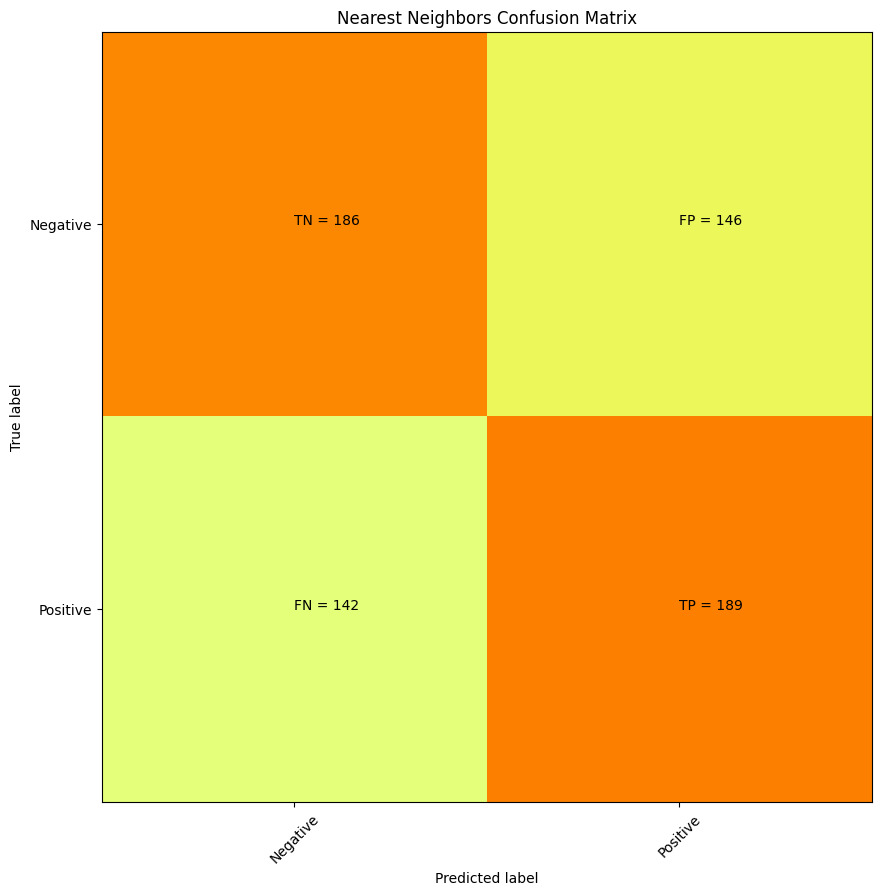

       adoption
1             1
9             1
19            1
32            1
41            1
...         ...
11689         0
3308          0
10715         0
5872          0
5529          0

[3312 rows x 1 columns] precision = 0.564179104477612 recall = 0.5709969788519638


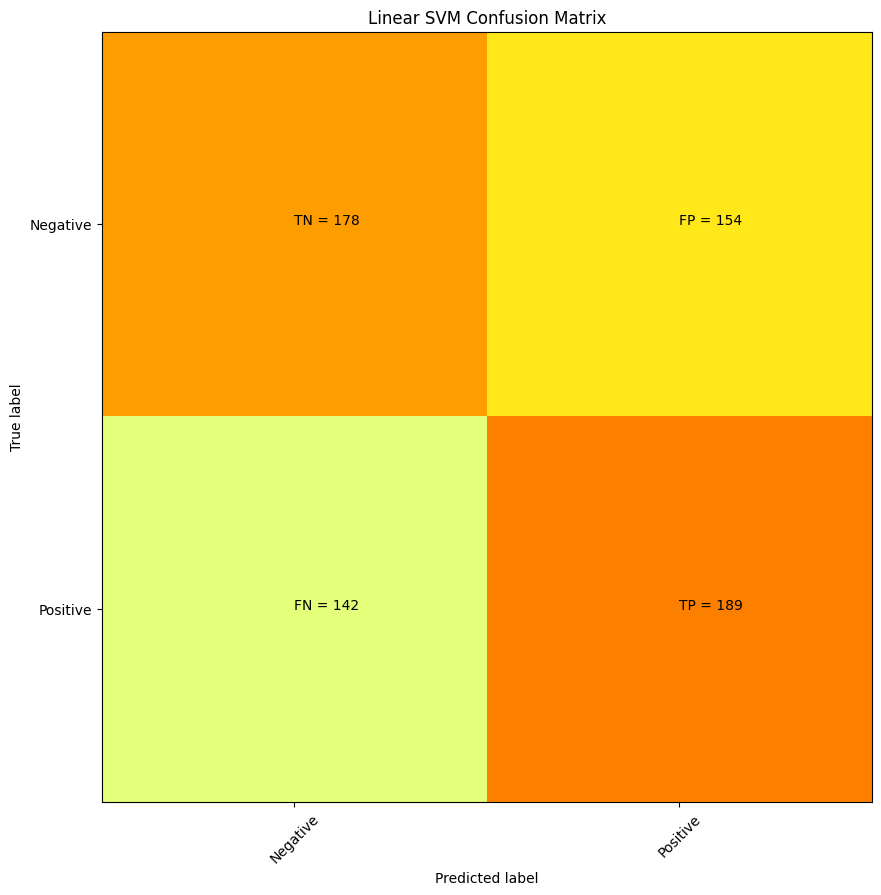

       adoption
1             1
9             1
19            1
32            1
41            1
...         ...
11689         0
3308          0
10715         0
5872          0
5529          0

[3312 rows x 1 columns] precision = 0.5510204081632653 recall = 0.5709969788519638


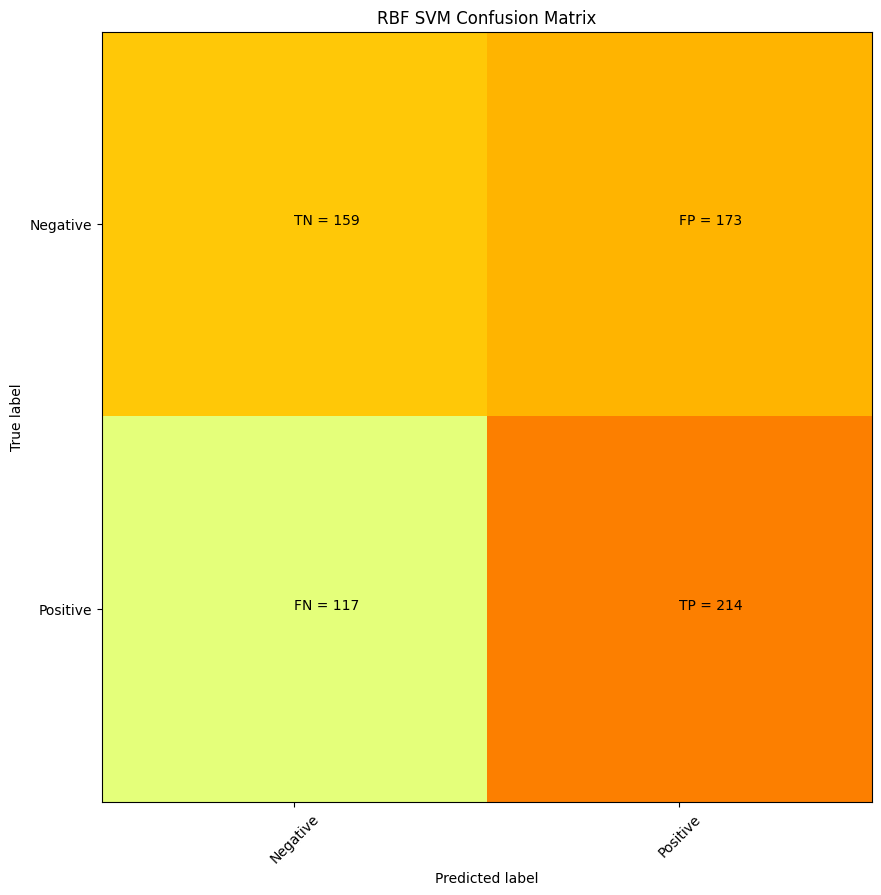

       adoption
1             1
9             1
19            1
32            1
41            1
...         ...
11689         0
3308          0
10715         0
5872          0
5529          0

[3312 rows x 1 columns] precision = 0.5529715762273901 recall = 0.6465256797583081


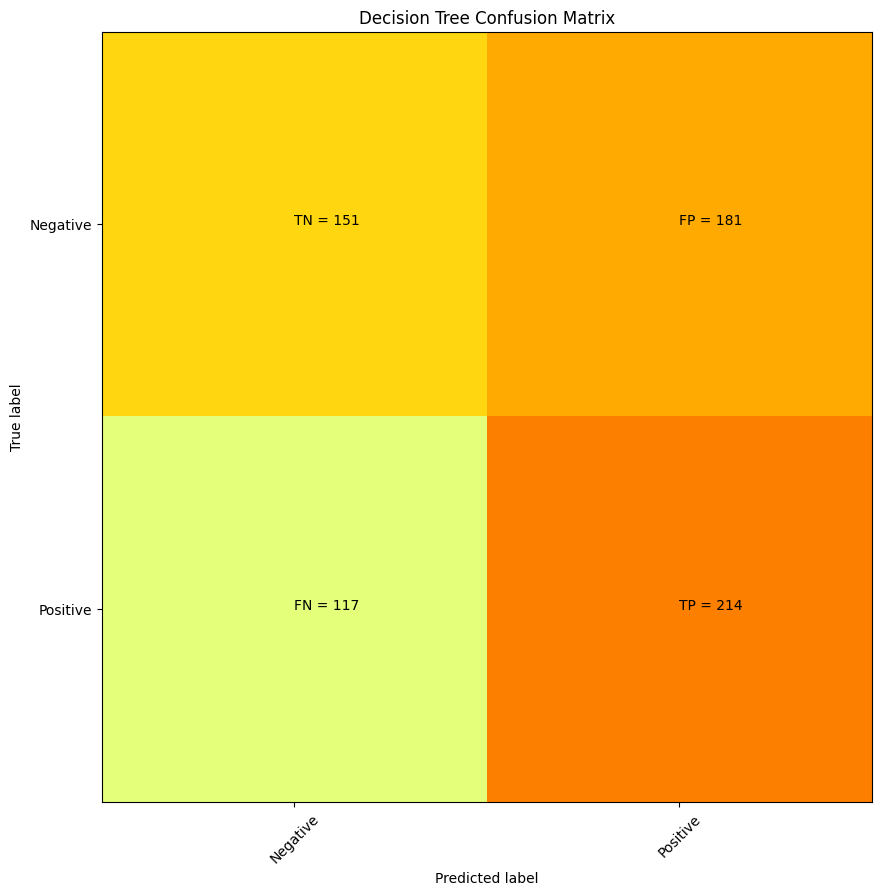

       adoption
1             1
9             1
19            1
32            1
41            1
...         ...
11689         0
3308          0
10715         0
5872          0
5529          0

[3312 rows x 1 columns] precision = 0.5417721518987342 recall = 0.6465256797583081


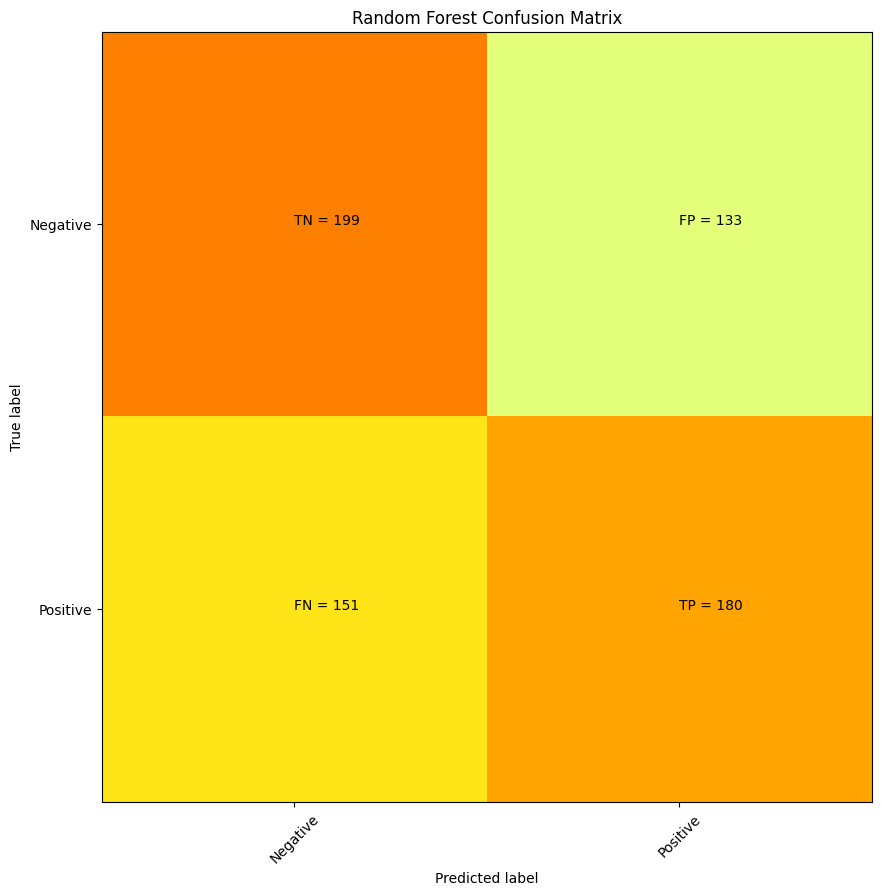

       adoption
1             1
9             1
19            1
32            1
41            1
...         ...
11689         0
3308          0
10715         0
5872          0
5529          0

[3312 rows x 1 columns] precision = 0.5750798722044729 recall = 0.5438066465256798


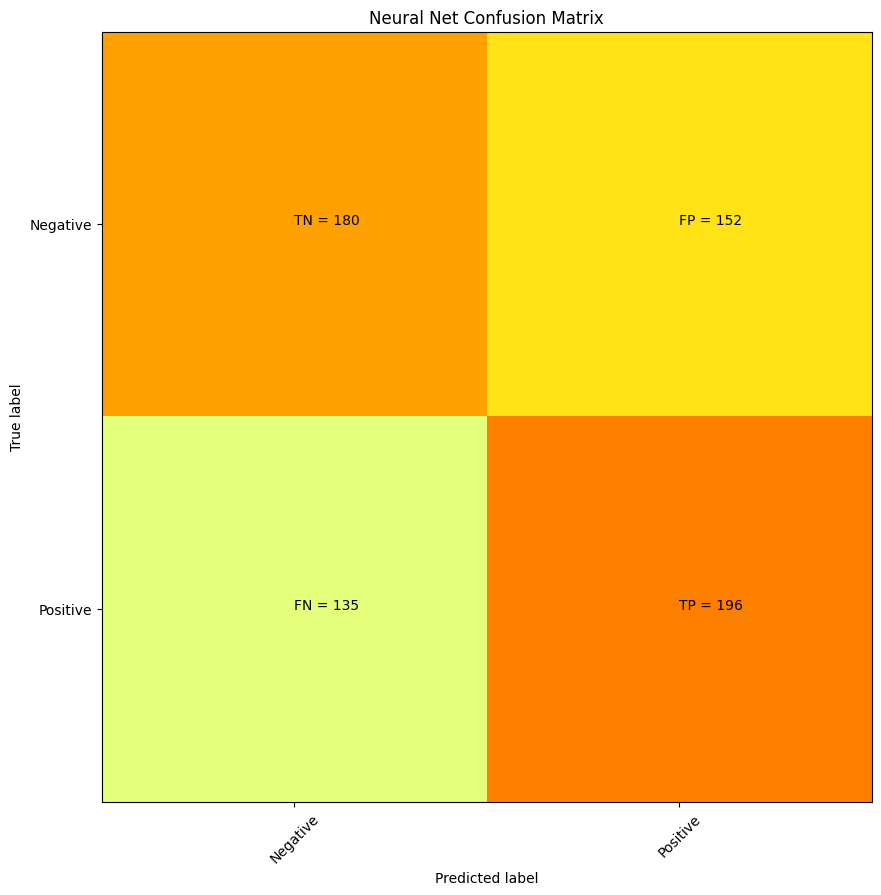

       adoption
1             1
9             1
19            1
32            1
41            1
...         ...
11689         0
3308          0
10715         0
5872          0
5529          0

[3312 rows x 1 columns] precision = 0.5632183908045977 recall = 0.5921450151057401


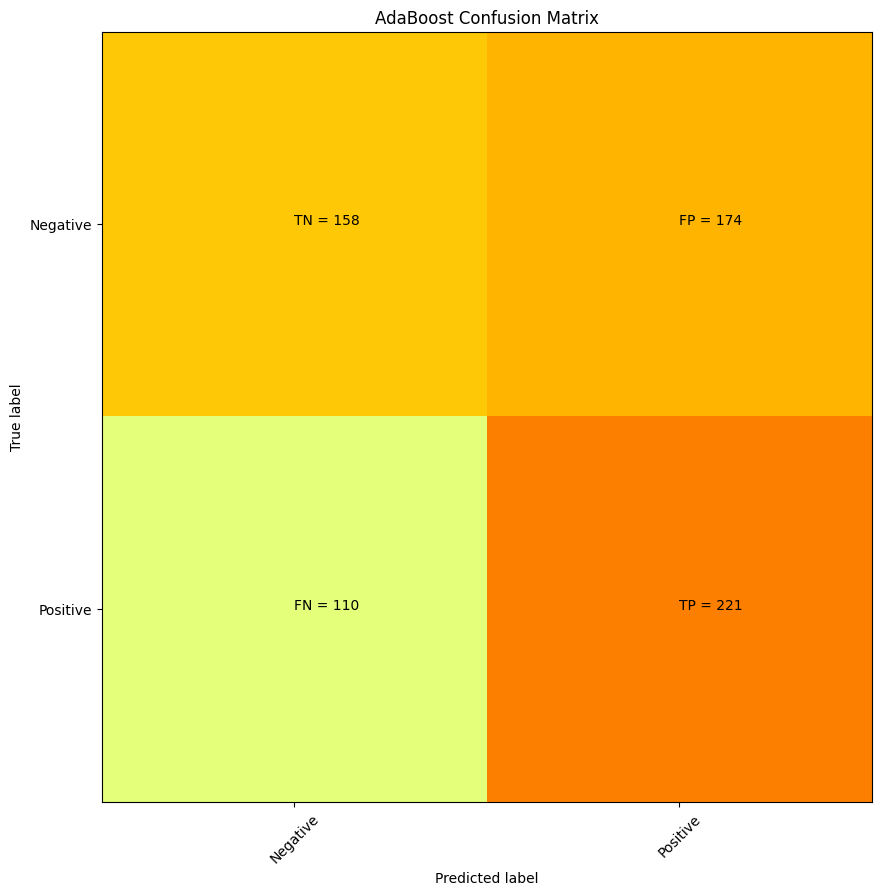

       adoption
1             1
9             1
19            1
32            1
41            1
...         ...
11689         0
3308          0
10715         0
5872          0
5529          0

[3312 rows x 1 columns] precision = 0.5594936708860759 recall = 0.6676737160120846


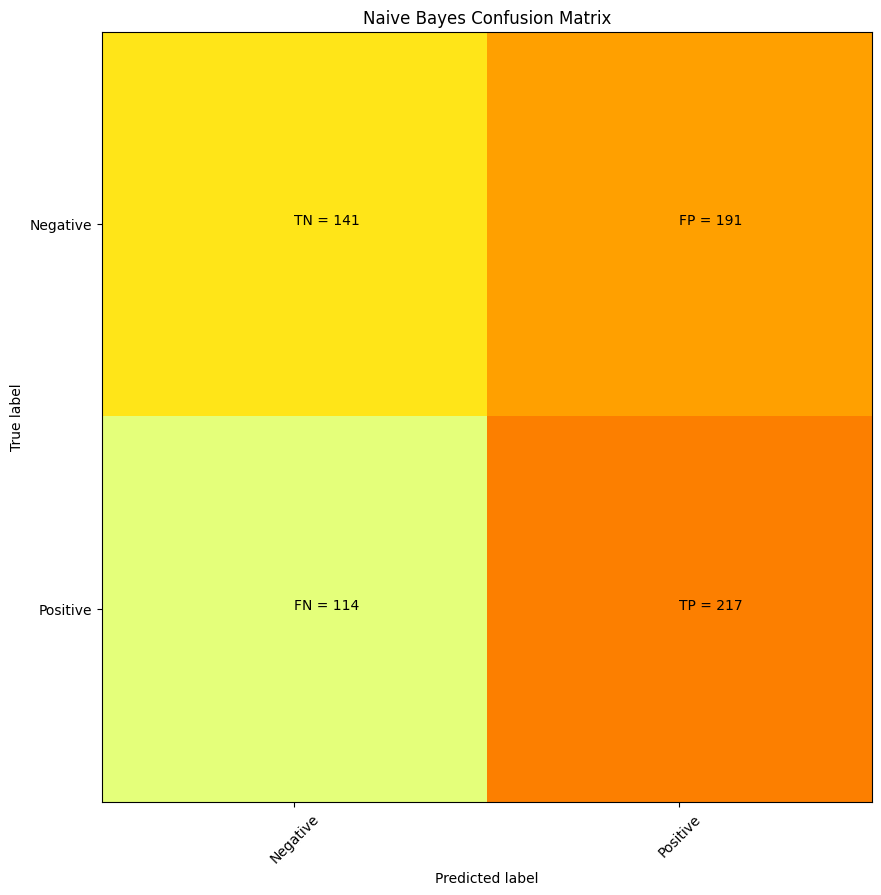

       adoption
1             1
9             1
19            1
32            1
41            1
...         ...
11689         0
3308          0
10715         0
5872          0
5529          0

[3312 rows x 1 columns] precision = 0.5318627450980392 recall = 0.6555891238670695


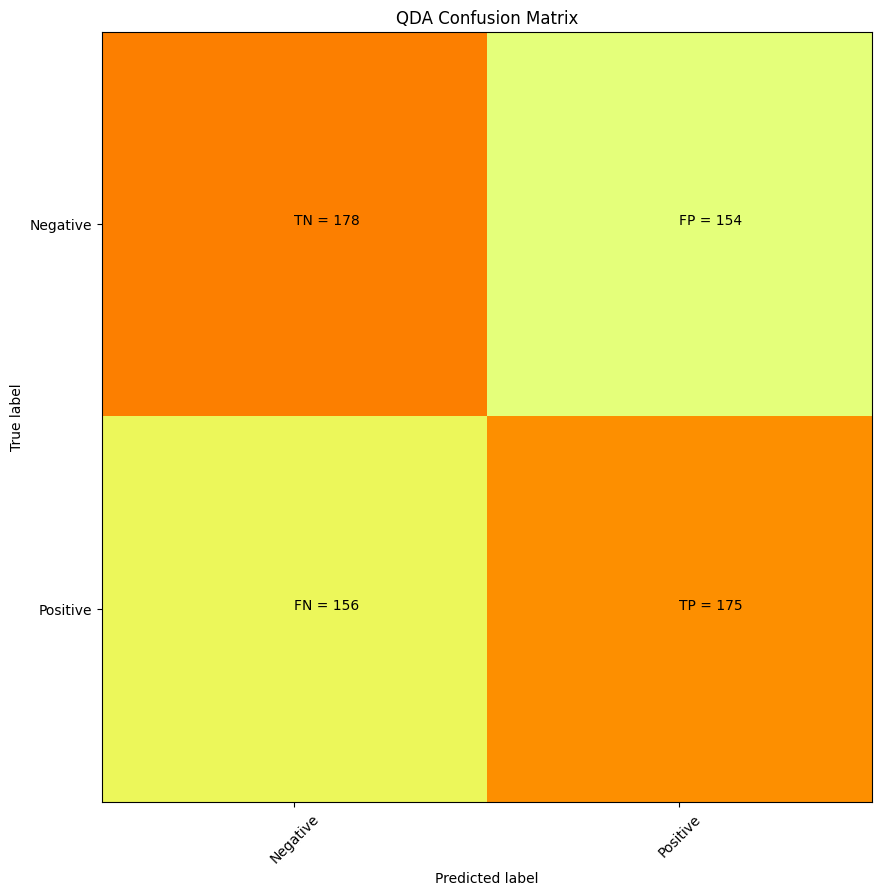

       adoption
1             1
9             1
19            1
32            1
41            1
...         ...
11689         0
3308          0
10715         0
5872          0
5529          0

[3312 rows x 1 columns] precision = 0.5319148936170213 recall = 0.5287009063444109
                Name  Score Train  Score Test  F1 score
0  Nearest Neighbors     0.767837    0.565611  0.567568
1         Linear SVM     0.590789    0.553544  0.560831
2            RBF SVM     0.830125    0.562594  0.596100
3      Decision Tree     0.928275    0.550528  0.589532
4      Random Forest     0.975085    0.571644  0.559006
5         Neural Net     0.606644    0.567119  0.577320
6           AdaBoost     0.621367    0.571644  0.608815
7        Naive Bayes     0.577199    0.539970  0.587280
8                QDA     0.564364    0.532428  0.530303


In [44]:
#score here is accuracy
#Hm, it's interesting that test and train accuracy are so good but the F1 score is so bad!
#Random forest seems to be doing the best, so let's go with that and try a hyperparameters earch to improve the f1 score
classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    DecisionTreeClassifier(max_depth=20),
    RandomForestClassifier(max_depth=20, n_estimators=10, max_features=30),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
]


names = [
    "Nearest Neighbors",
    "Linear SVM",
    "RBF SVM",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "AdaBoost",
    "Naive Bayes",
    "QDA",
]

score_tracker=pd.DataFrame(columns=["Name", "Score Train", "Score Test", 'F1 score'])

# preprocess dataset, split into training and test part
X_train, X_test, y_train, y_test = train_test_split(X,  y, test_size=0.2, random_state=49, stratify=y)


 # iterate over classifiers
for name, clf in zip(names, classifiers):

    clf = make_pipeline(StandardScaler(), clf)
    clf.fit(X_train, y_train)
    score_train = clf.score(X_train, y_train)
    score_test = clf.score(X_test, y_test)
    preds = clf.predict(X_test)
    # f1 = f1_score(y_test, clf.predict(X_test))
    f1 = f1_score(y_test, preds)
    temp = {"Name":name, "Score Train": score_train, "Score Test":score_test, "F1 score":f1}
    score_tracker = score_tracker.append(temp, ignore_index=True)
    precision, recall = confusio_matrix(y_test, preds, y, name)
print(score_tracker)

In [45]:
abc = AdaBoostClassifier(base_estimator=DecisionTreeClassifier())

# preprocess dataset, split into training and test part
X_train, X_test, y_train, y_test = train_test_split(X,  y, test_size=0.2, random_state=49, stratify=y)

parameters = {'base_estimator__max_depth':[i for i in range(2,11,2)],
              'base_estimator__min_samples_leaf':[5,10],
              'n_estimators':[10,50,250,1000],
              'learning_rate':[0.01,0.1]}

clf = GridSearchCV(abc, parameters,verbose=3,scoring='f1',n_jobs=-1)
clf.fit(X_train,y_train)

results = pd.DataFrame(clf.cv_results_)

results



Fitting 5 folds for each of 80 candidates, totalling 400 fits


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        0.062739      0.001089         0.020026        0.003569   
1        0.259369      0.009246         0.033064        0.001316   
2        1.806346      0.411890         0.166528        0.041332   
3        5.661925      0.703769         0.468101        0.141470   
4        0.112317      0.020729         0.032829        0.009485   
..            ...           ...              ...             ...   
75      11.947905      0.168115         0.562536        0.190188   
76       0.108283      0.003041         0.019563        0.004468   
77       0.512164      0.008150         0.032597        0.001069   
78       2.948487      0.743052         0.118187        0.005777   
79      11.019093      1.843428         0.480410        0.212903   

   param_base_estimator__max_depth param_base_estimator__min_samples_leaf  \
0                                2                                      5   
1                                2                                      5   
2                                2                                      5   
3                                2                                      5   
4                                2                                      5   
..                             ...                                    ...   
75                              10                                     10   
76                              10                                     10   
77                              10                                     10   
78                              10                                     10   
79                              10                                     10   

   param_learning_rate param_n_estimators  \
0                 0.01                 10   
1                 0.01                 50   
2                 0.01                250   
3                 0.01               1000   
4                  0.1                 10   
..                 ...                ...   
75                0.01               1000   
76                 0.1                 10   
77                 0.1                 50   
78                 0.1                250   
79                 0.1               1000   

                                               params  split0_test_score  \
0   {'base_estimator__max_depth': 2, 'base_estimat...           0.604491   
1   {'base_estimator__max_depth': 2, 'base_estimat...           0.604491   
2   {'base_estimator__max_depth': 2, 'base_estimat...           0.625000   
3   {'base_estimator__max_depth': 2, 'base_estimat...           0.640264   
4   {'base_estimator__max_depth': 2, 'base_estimat...           0.592322   
..                                                ...                ...   
75  {'base_estimator__max_depth': 10, 'base_estima...           0.567273   
76  {'base_estimator__max_depth': 10, 'base_estima...           0.593220   
77  {'base_estimator__max_depth': 10, 'base_estima...           0.553345   
78  {'base_estimator__max_depth': 10, 'base_estima...           0.553734   
79  {'base_estimator__max_depth': 10, 'base_estima...           0.560440   

    split1_test_score  split2_test_score  split3_test_score  \
0            0.626712           0.609174           0.659341   
1            0.609346           0.609174           0.630597   
2            0.638225           0.655914           0.674380   
3            0.640809           0.646749           0.673267   
4            0.642735           0.597980           0.630597   
..                ...                ...                ...   
75           0.585009           0.576642           0.575540   
76           0.594306           0.601802           0.616438   
77           0.554128           0.579235           0.587189   
78           0.572477           0.560606           0.539033   
79           0.576147           0.546490           0.560579   

    split4_test_score  mean_test_score  std_test_sc

In [49]:
results.sort_values(by=["split0_test_score","split1_test_score","split2_test_score"], ascending=False)
# results.iloc[25:26,8 :9].values
#Highest score, still not great but better than chance, goes to these parameters:
# {'base_estimator__max_depth': 4, 'base_estimator__min_samples_leaf': 10, 'learning_rate': 0.01, 'n_estimators': 50}

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
25       0.462448      0.115769         0.051138        0.017183   
44       0.146272      0.018366         0.027884        0.007767   
26       2.379683      1.017671         0.116671        0.012437   
57       0.453532      0.008816         0.035085        0.002290   
18       2.378444      1.054842         0.217709        0.199356   
..            ...           ...              ...             ...   
66       2.690409      0.065729         0.121714        0.004474   
35       9.944563      0.957521         0.427297        0.025567   
70       3.435277      1.254374         0.163409        0.057778   
54       3.013743      0.923269         0.179559        0.066948   
51      11.340595      1.387855         0.445147        0.019708   

   param_base_estimator__max_depth param_base_estimator__min_samples_leaf  \
25                               4                                     10   
44                               6                                     10   
26                               4                                     10   
57                               8                                     10   
18                               4                                      5   
..                             ...                                    ...   
66                              10                                      5   
35                               6                                      5   
70                              10                                      5   
54                               8                                      5   
51                               8                                      5   

   param_learning_rate param_n_estimators  \
25                0.01                 50   
44                 0.1                 10   
26                0.01                250   
57                0.01                 50   
18                0.01                250   
..                 ...                ...   
66                0.01                250   
35                0.01               1000   
70                 0.1                250   
54                 0.1                250   
51                0.01               1000   

                                               params  split0_test_score  \
25  {'base_estimator__max_depth': 4, 'base_estimat...           0.662400   
44  {'base_estimator__max_depth': 6, 'base_estimat...           0.650641   
26  {'base_estimator__max_depth': 4, 'base_estimat...           0.650407   
57  {'base_estimator__max_depth': 8, 'base_estimat...           0.650407   
18  {'base_estimator__max_depth': 4, 'base_estimat...           0.649435   
..                                                ...                ...   
66  {'base_estimator__max_depth': 10, 'base_estima...           0.544790   
35  {'base_estimator__max_depth': 6, 'base_estimat...           0.544144   
70  {'base_estimator__max_depth': 10, 'base_estima...           0.541436   
54  {'base_estimator__max_depth': 8, 'base_estimat...           0.538899   
51  {'base_estimator__max_depth': 8, 'base_estimat...           0.530612   

    split1_test_score  split2_test_score  split3_test_score  \
25           0.639594           0.684838           0.678869   
44           0.660194           0.640545           0.664516   
26           0.650083           0.662139           0.679803   
57           0.601375           0.617021           0.642263   
18           0.651240           0.662116           0.669951   
..                ...                ...                ...   
66           0.555354           0.582090           0.561922   
35           0.565543           0.587156           0.580292   
70           0.549165           0.557621           0.578755   
54           0.547794           0.553672           0.567273   
51           0.578850           0.554717           0.571956   

    split4_test_score  mean_test_score  std_test_sc

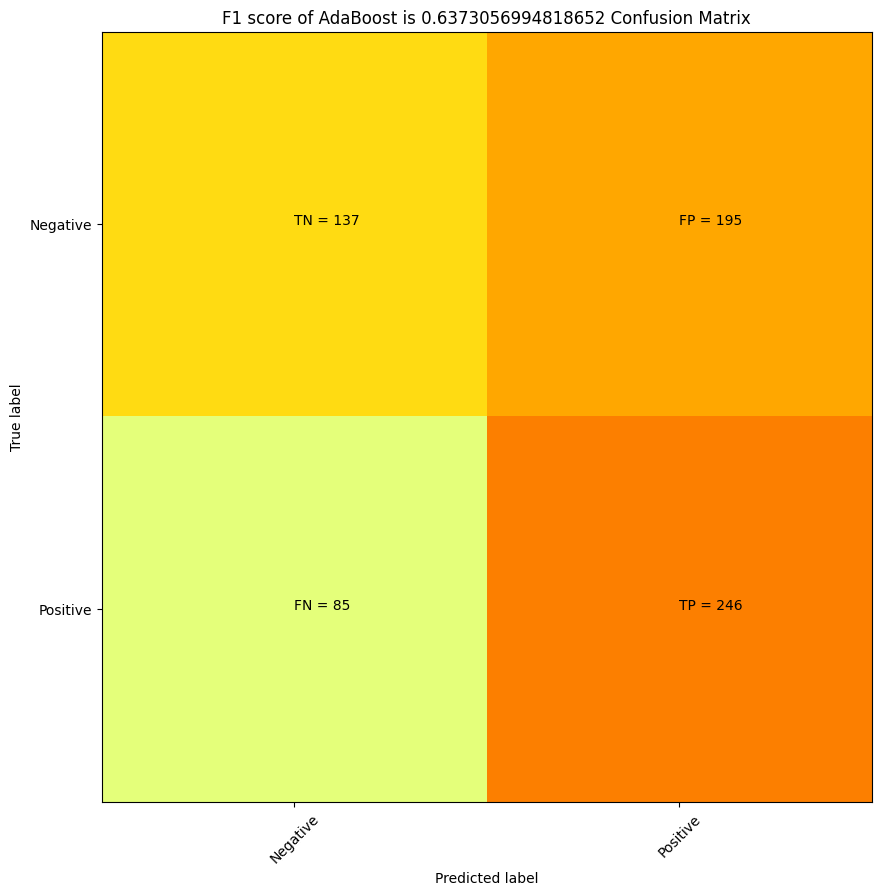

       adoption
1             1
9             1
19            1
32            1
41            1
...         ...
11689         0
3308          0
10715         0
5872          0
5529          0

[3312 rows x 1 columns] precision = 0.5578231292517006 recall = 0.743202416918429


In [65]:
# parameters = {'base_estimator__max_depth': 4, 'base_estimator__min_samples_leaf': 10, 'learning_rate': 0.01, 'n_estimators': 50}

base = DecisionTreeClassifier(max_depth = 4, min_samples_leaf= 10)

abc = AdaBoostClassifier(base_estimator=base, learning_rate = 0.01, n_estimators= 50 )

# preprocess dataset, split into training and test part
X_train, X_test, y_train, y_test = train_test_split(X,  y, test_size=0.2, random_state=49, stratify=y)


abc.fit(X_train,y_train)

score_train = abc.score(X_train, y_train)
score_test = abc.score(X_test, y_test)
preds = abc.predict(X_test)
f1 = f1_score(y_test, preds)
f2 = f1.astype(str)
precision, recall = confusio_matrix(y_test, preds, y, "F1 score of AdaBoost is " + f2)




In [69]:
abc.feature_importances_


array([0.01762153, 0.        , 0.25094538, 0.00122355, 0.19814868,
       0.3373762 , 0.01704956, 0.02188505, 0.00565451, 0.13918995,
       0.        , 0.01090559])

In [77]:

columns = ['opted_in_to_mailing_list', 'enabled_for_marketing_drip', 'org_id',
       'invited_by_user_id', 'Year', 'Month', 'DayOfWeek', 'GUEST_INVITE',
       'ORG_INVITE', 'PERSONAL_PROJECTS', 'SIGNUP', 'SIGNUP_GOOGLE_AUTH']

importances = [0.01762153, 0, 0.25094538, 0.00122355, 0.19814868,
       0.3373762 , 0.01704956, 0.02188505, 0.00565451, 0.13918995,
       0, 0.01090559]

# The most important feature is the month of sign up which reflects when the account was made. Have there been version changes across these months?
# Next up is org_id! This seems intuitive - if their place of work uses this service, they are more likely to keep using the product.




ValueError: ignored

In [78]:
sampled

object_id               name                          email  \
1              2      Poole Matthew         MatthewPoole@gustr.com   
9             10       Santos Carla  CarlaFerreiraSantos@gustr.com   
19            20      Helms Mikayla             lqyvjilf@uhzdq.com   
32            33        Araujo José     JoseMartinsAraujo@cuvox.de   
41            42     Pinto Giovanna    GiovannaCunhaPinto@cuvox.de   
...          ...                ...                            ...   
11689      11690  Christensen Sofia             esgblccc@gwsyp.com   
3308        3309          Dias Luiz     LuizSantosDias@hotmail.com   
10715      10716         Cunha Anna   AnnaRodriguesCunha@yahoo.com   
5872        5873       Barros Lucas   LucasCostaBarros@hotmail.com   
5529        5530      Slater Dakota         DakotaSlater@yahoo.com   

       opted_in_to_mailing_list  enabled_for_marketing_drip  org_id  \
1                             0                           0       1   
9                             1                           1     318   
19                            0                           0      58   
32                            0                           0     401   
41                            1                           0     235   
...                         ...                         ...     ...   
11689                         0                           0      92   
3308                          1                           1     177   
10715                         0                           0     403   
5872                          1                           0     179   
5529                          1                           1     251   

       invited_by_user_id  adoption  Year  Month  DayOfWeek  GUEST_INVITE  \
1                       1         1  2013     11          4             0   
9                       1         1  2013      1          2             0   
19                      0         1  2014      3          3             0   
32                      1         1  2014      3          1             1   
41                      0         1  2012     11          6             0   
...                   ...       ...   ...    ...        ...           ...   
11689                   0         0  2013     12          6             0   
3308                    0         0  2014      5          0             0   
10715                   0         0  2013      7          5             0   
5872                    1         0  2013      6          5             0   
5529                    1         0  2014      3          5             0   

       ORG_INVITE  PERSONAL_PROJECTS  SIGNUP  SIGNUP_GOOGLE_AUTH  
1               1                  0       0                   0  
9               1                  0       0                   0  
19              0                  0       1                   0  
32              0                  0       0                   0  
41              0                  0       1                   0  
...           ...                ...     ...                 ...  
11689           0                  0       1                   0  
3308            0                  0       1                   0  
10715           0                  1       0                   0  
5872            1                  0       0                   0  
5529            1                  0       0                   0  

[3312 rows x 16 columns]

<function matplotlib.pyplot.show(close=None, block=None)>

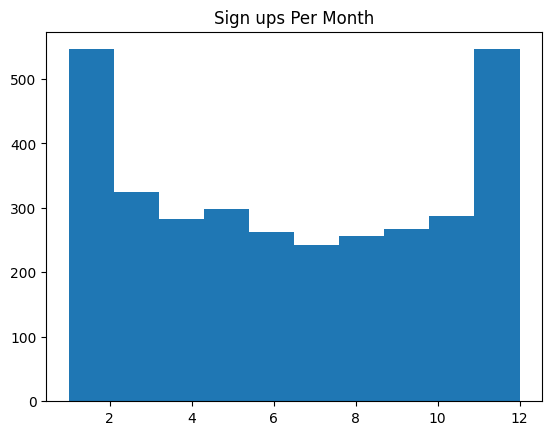

In [79]:
plt.hist(sampled.Month)
plt.title('Sign ups Per Month')
plt.show


<function matplotlib.pyplot.show(close=None, block=None)>

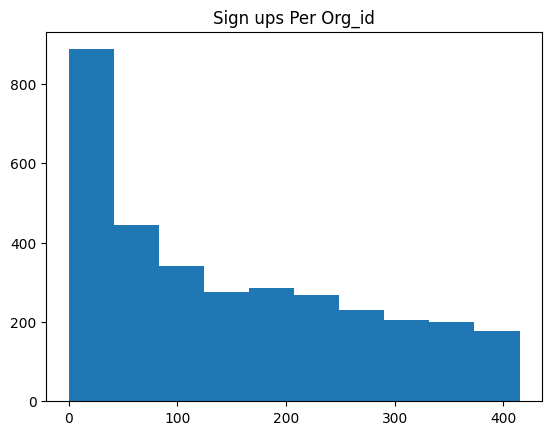

In [81]:
plt.hist(sampled.org_id)
plt.title('Sign ups Per Org_id')
plt.show